In [19]:
import sys
import tensorflow as tf
import os
import matplotlib.image as mpimg
import pandas as pd
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
# 1. Réduire les logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print(f"🐍 Version Python : {sys.version.split()[0]}")
print(f"🤖 Version TensorFlow : {tf.__version__}")

try:
    print("\n--- État Système (nvidia-smi) ---")
    !nvidia-smi
except:
    print("Commande nvidia-smi non disponible (ce n'est pas grave sous Windows natif)")

print("\n--- Détection TensorFlow ---")
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("❌ Aucun GPU détecté par TensorFlow.")
    print("Causes possibles :")
    print("1. Vous n'avez pas installé 'tensorflow[and-cuda]'")
    print("2. Votre version de Python (3.13) n'est pas supportée.")
    print("3. La variable CUDA_VISIBLE_DEVICES = -1 est restée active.")
else:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU configuré : Mémoire dynamique activée")
    except RuntimeError as e:
        print(f"Erreur config GPU : {e}")

🐍 Version Python : 3.10.19
🤖 Version TensorFlow : 2.20.0

--- État Système (nvidia-smi) ---
Thu Jan 29 12:16:56 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              2W /   80W |    2211MiB /   8188MiB |      0%      Default |
|                                         |     

In [7]:
MODEL_NAME = "model_dog_from_scratch"
CHECKPOINT_NAME = f"{MODEL_NAME}_checkpoint.keras"
FINAL_MODEL_NAME = f"{MODEL_NAME}_final.keras"

# Dossier d'images d'entraînement au format .jpg
path_train_dataset = '../dataset/Dog-Breed-Identification/train'
# Dossier d'images de test au format .jpg
path_test_dataset = '../dataset/Dog-Breed-Identification/test'
# Fichier des labels / classes au format .csv
path_features = '../dataset/Dog-Breed-Identification/labels.csv'
images_train_dataset = os.listdir(path_train_dataset)
images_test_dataset = os.listdir(path_test_dataset)


labels_df = pd.read_csv(path_features)
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
print(' No# of train images in data:', len(images_train_dataset))
print(' No# of test images in data:', len(images_test_dataset))

 No# of train images in data: 10222
 No# of test images in data: 10357


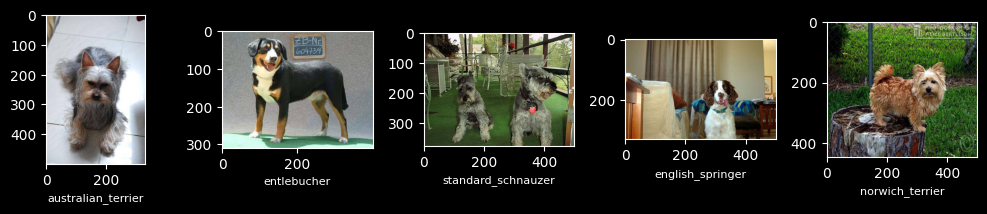

In [9]:
plt.figure(figsize=(10, 10))

# On boucle sur les 5 premières images
for i in range(5):
    plt.subplot(5, 5, i+1)
    
    # 1. Récupérer le nom du fichier
    filename = images_train_dataset[i]
    
    # 2. Construire le chemin complet vers l'image
    img_path = os.path.join(path_train_dataset, filename)
    
    # 3. Charger l'image réelle (les pixels)
    img = mpimg.imread(img_path)
    
    # 4. Afficher l'image
    plt.imshow(img)
    
    # 5. Récupérer le label correct
    img_id = filename.split('.')[0]

    try:
        label = labels_df.loc[labels_df['id'] == img_id, 'breed'].values[0]
    except IndexError:
        label = "Inconnu"

    plt.xlabel(label, fontsize=8)

plt.tight_layout()
plt.show()

In [10]:
batch_size = 16
seed = 42
shuffle = True

# Reconstitution des noms des fchiers d'images
labels_df['id'] = labels_df['id'].apply(lambda x: x + ".jpg")
print(labels_df.head())

# Création du générateur avec augmentation de données
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

# Configuration pour l'entraînement avec un peu d'augmentation de données
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisation des pixels entre 0 et 1
    validation_split=0.2,   # 20% des données serviront à la validation
    rotation_range=40,      # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal
    height_shift_range=0.2, # Décalage vertical
    horizontal_flip=True,   # Retournement horizontal (miroir)
    fill_mode="nearest"
)

# Configuration pour la validation
valid_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2
)

# Entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=path_train_dataset,
    x_col="id",
    y_col="breed",
    subset="training",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=path_train_dataset,
    x_col="id",
    y_col="breed",
    subset="validation",
    batch_size=batch_size,
    seed=seed,
    shuffle=shuffle,
    class_mode="categorical",
    target_size=(224, 224)
)

                                     id             breed
0  000bec180eb18c7604dcecc8fe0dba07.jpg       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97.jpg             dingo
2  001cdf01b096e06d78e9e5112d419397.jpg          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d.jpg          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62.jpg  golden_retriever
Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [11]:
print(train_generator.class_indices)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

In [12]:
num_classes = len(train_generator.class_indices)
# Nombre de filtres (on commence petit et on augmente)
# Architecture inspirée de VGG (Conv-Conv-Pool)
model = Sequential([

    # --- BLOC 1 : Détails fins (64 filtres) ---
    Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), use_bias=False),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(32, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # --- BLOC 2 : Formes (64 filtres) ---
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # --- BLOC 3 : Concepts (128 filtres) ---
    Conv2D(128, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(128, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # --- BLOC 4 : Concepts complexes (256 filtres) ---
    Conv2D(256, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # --- TÊTE DU RÉSEAU ---
    GlobalAveragePooling2D(),

    Dense(512, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

# Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/home/leolchalot/anaconda3/envs/tf_gpu_stable/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1769685418.495339  105929 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3960 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       294,91

 Total params: 778,968 (2.97 MB)

 Trainable params: 776,536 (2.96 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [13]:
# 1. Sauvegarde
checkpoint = ModelCheckpoint(f"models/{MODEL_NAME}/checkpoints/{CHECKPOINT_NAME}",
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

# 2. Arrêt automatique (Patience augmentée à 8 car l'apprentissage from scratch est lent)
early_stop = EarlyStopping(monitor='val_loss',
                           patience=8,
                           restore_best_weights=True)

# 3. Ralentissement automatique (INDISPENSABLE ici)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,    # On divise le Learning Rate par 5
                              patience=3,    # Si pas d'amélioration pendant 3 époques
                              min_lr=1e-6,   # Ne pas descendre trop bas
                              verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

# 4. Lancement (50 époques recommandées)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    callbacks=callbacks_list
)

Epoch 1/50


2026-01-29 12:17:01.226856: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ced900022a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-29 12:17:01.226877: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-29 12:17:01.281862: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-29 12:17:01.628217: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801


  2/512 ━━━━━━━━━━━━━━━━━━━━ 35s 69ms/step - accuracy: 0.0156 - loss: 5.0674       

I0000 00:00:1769685429.697807  106658 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.0137 - loss: 5.3995
Epoch 1: val_accuracy improved from None to 0.01027, saving model to models/model_dog_from_scratch/checkpoints/model_dog_from_scratch_checkpoint.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 68s 112ms/step - accuracy: 0.0127 - loss: 5.2492 - val_accuracy: 0.0103 - val_loss: 4.8938 - learning_rate: 0.0010
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0134 - loss: 5.0146
Epoch 2: val_accuracy did not improve from 0.01027
512/512 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.0127 - loss: 5.0087 - val_accuracy: 0.0098 - val_loss: 4.8379 - learning_rate: 0.0010
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.0183 - loss: 4.9243
Epoch 3: val_accuracy improved from 0.01027 to 0.01370, saving model to models/model_dog_from_scratch/checkpoints/model_dog_from_scratch_checkpoint.keras
512/512 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - accuracy: 0.0172 - loss: 4.8937 - val_accuracy: 0.0137 - val_

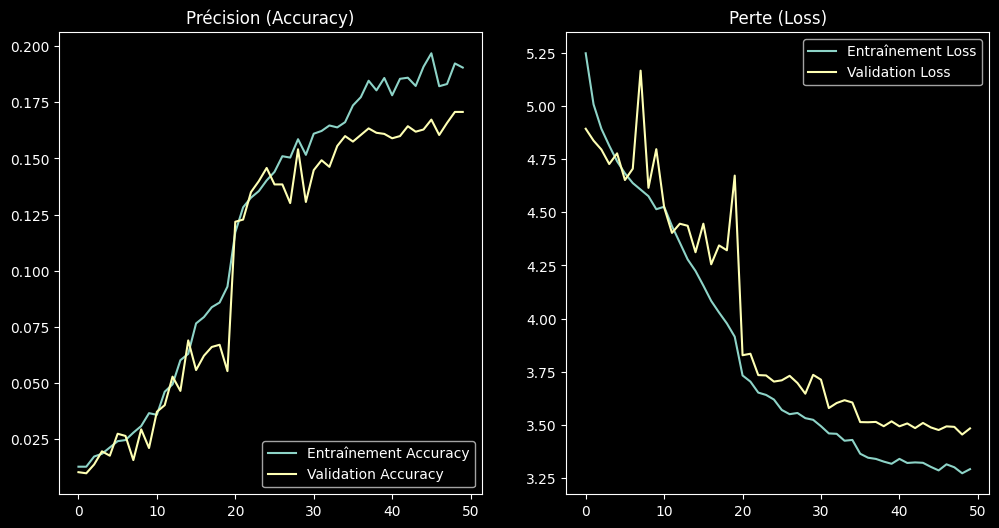

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Courbe de Précision
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entraînement Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Précision (Accuracy)')

# Courbe de Perte
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entraînement Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Perte (Loss)')
plt.show()

In [15]:
# Sauvegarde au format de Keras
model.save(f"models/{MODEL_NAME}/{FINAL_MODEL_NAME}")
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step


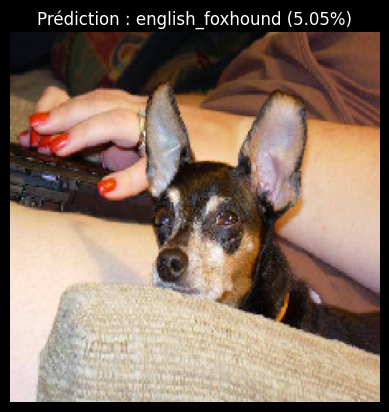

In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

labels_map = {v: k for k, v in train_generator.class_indices.items()}

def predict_breed(img_path):
    # Charger l'image et la redimensionner comme à l'entraînement (224x224)
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convertir en tableau de nombres (array)
    img_array = image.img_to_array(img)
    
    # Normaliser (diviser par 255 comme lors de l'entraînement)
    img_array = img_array / 255.0
    
    # Ajouter une dimension pour simuler un batch de 1 image (1, 224, 224, 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Faire la prédiction
    predictions = model.predict(img_array)
    
    # Trouver l'index de la probabilité la plus élevée
    predicted_class_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100
    
    predicted_breed = labels_map[predicted_class_index]
    
    # Affichage
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction : {predicted_breed} ({confidence:.2f}%)")
    plt.show()

# --- UTILISATION ---
# Remplacez par le chemin d'une image de votre dossier de test
test_image_path = os.path.join(path_test_dataset, os.listdir(path_test_dataset)[1])
predict_breed(test_image_path)

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
import time

# 1. Configuration Mémoire (Toujours indispensable sur RTX 4000)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 2. Activer Mixed Precision (Boost énorme sur RTX 4060)
mixed_precision.set_global_policy('mixed_float16')

# --- FONCTION DE TEST ---
def benchmark(device_name, steps=10):
    print(f"\n--- Test sur {device_name} en cours... ---")
    with tf.device(device_name):
        # Création d'un modèle factice
        model = MobileNetV2(weights=None, input_shape=(224, 224, 3), classes=120)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        
        # Données factices (plus rapide que de charger depuis le disque)
        import numpy as np
        fake_data = np.random.random((16, 224, 224, 3)).astype('float32')
        fake_labels = np.random.random((16, 120)).astype('float32')
        
        # Chauffe (Warm-up)
        model.train_on_batch(fake_data, fake_labels)
        
        # Mesure
        start = time.time()
        for _ in range(steps):
            model.train_on_batch(fake_data, fake_labels)
        end = time.time()
        
        avg_time = (end - start) / steps
        print(f"⏱️ Temps moyen par batch : {avg_time*1000:.1f} ms")
        return avg_time

# --- RÉSULTATS ---
t_cpu = benchmark('/CPU:0')
t_gpu = benchmark('/GPU:0')

print(f"\n🚀 ACCÉLÉRATION : Le GPU est {t_cpu/t_gpu:.1f}x plus rapide que le CPU !")


--- Test sur /CPU:0 en cours... ---


2026-01-29 12:59:27.962476: I external/local_xla/xla/service/service.cc:163] XLA service 0x32fca020 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-29 12:59:27.962491: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version


⏱️ Temps moyen par batch : 1558.8 ms

--- Test sur /GPU:0 en cours... ---
⏱️ Temps moyen par batch : 18.6 ms

🚀 ACCÉLÉRATION : Le GPU est 83.7x plus rapide que le CPU !


In [18]:
import json

# Récupérer le mapping (ex: {'beagle': 0, 'boxer': 1})
class_indices = train_generator.class_indices

# Inverser pour avoir {0: 'beagle', 1: 'boxer'}
idx_to_class = {v: k for k, v in class_indices.items()}

# Sauvegarder dans un fichier
with open('class_indices.json', 'w') as f:
    json.dump(idx_to_class, f)

print("✅ Fichier class_indices.json généré !")

✅ Fichier class_indices.json généré !
